# Colouring Image Using Resnet and Autoencoders



In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


# Read in Data


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = ''
OUTPUT_DIR = ''
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_ids = next(os.walk(TRAIN_PATH))[2]

In [3]:
%%time
X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 2128/2128 [00:57<00:00, 36.80it/s]


Total missing: 86
CPU times: user 1min 24s, sys: 1min 13s, total: 2min 37s
Wall time: 59.3 s


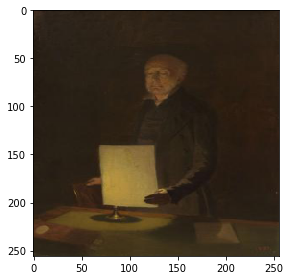

In [14]:
imshow(X_train[6])
plt.show()

# Train/Test Split
Just getting a sample of 20 images to test the model when it is done.

In [5]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=seed)

# Creating Model

The model combines autoencoder and resnet classifier. A autoencoder by itself is just shade everything in a brownish tone. The model uses an resnet classifier to give the neural network an idea of what things should be colored.

In [6]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('../input/inception-resnet-v2-weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

In [7]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_206

# Data Generator Functions

In [8]:
%%time

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

#Generate training data
def image_a_b_gen(dataset=X_train, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch

CPU times: user 189 µs, sys: 0 ns, total: 189 µs
Wall time: 194 µs


# Checkpoints

In [9]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Art_Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

# Train the Model

In [10]:
%%time
BATCH_SIZE = 20
model.fit_generator(image_a_b_gen(X_train,BATCH_SIZE),
            epochs=30,
            verbose=1,
            steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
             callbacks=model_callbacks
                   )

Epoch 1/30
102/101 [==============================] - 173s 2s/step - loss: 0.0064
Epoch 2/30
102/101 [==============================] - 151s 1s/step - loss: 0.0052
Epoch 3/30
102/101 [==============================] - 156s 2s/step - loss: 0.0051
Epoch 4/30
102/101 [==============================] - 155s 2s/step - loss: 0.0050
Epoch 5/30
102/101 [==============================] - 153s 2s/step - loss: 0.0046
Epoch 6/30
102/101 [==============================] - 154s 2s/step - loss: 0.0045
Epoch 7/30
102/101 [==============================] - 156s 2s/step - loss: 0.0044
Epoch 8/30
102/101 [==============================] - 156s 2s/step - loss: 0.0044
Epoch 9/30
102/101 [==============================] - 154s 2s/step - loss: 0.0043
Epoch 10/30
102/101 [==============================] - 153s 2s/step - loss: 0.0042
Epoch 11/30
102/101 [==============================] - 155s 2s/step - loss: 0.0044
Epoch 12/30
102/101 [==============================] - 158s 2s/step - loss: 0.0042
Epoch 13/30
1

In [ ]:
model.save(filepath)
model.save(os.path.join(OUTPUT_DIR, 'art_colorizer.h5'))


# Sample the Results

In [12]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

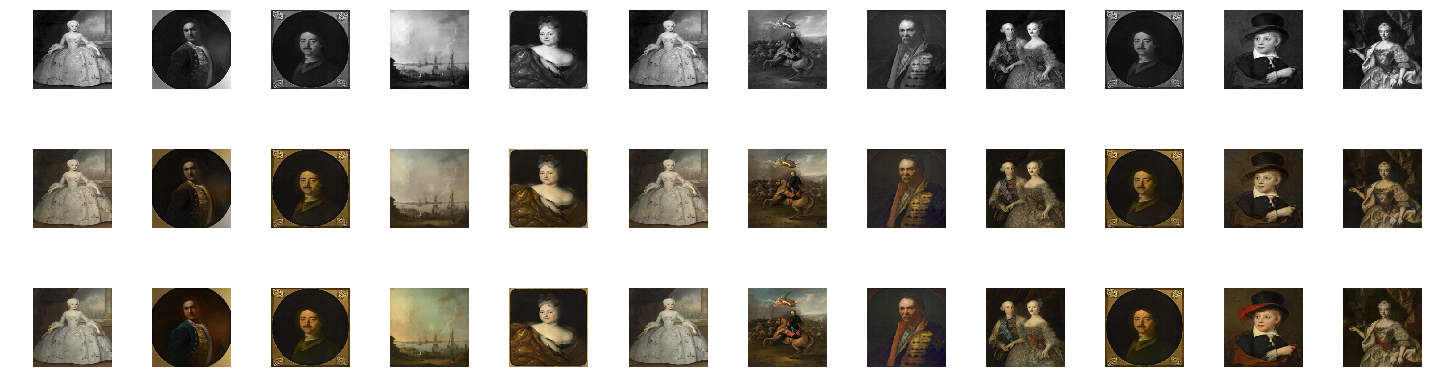

In [21]:
plt.figure(figsize=(20, 6))
for i in range(12):
    # grayscale
    plt.subplot(3, 12, i + 1)
    plt.imshow(rgb2gray(X_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.subplot(3, 12, i + 1 +12)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.subplot(3, 12, i + 1 + 24)
    plt.imshow(X_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()